## Постановка задачи:

Требуется построить и протестировать классификатор многомерных объектов на основе обучающей выборки - модельные данные и данные из репозитория.
___

## Реализиция: модельные данные

### Построение дискриминантной функции по обучающей выборке, классификация тестовой выборки

Бинарный классификатор должен быть протестирован для двух случаев: хорошо и плохо разделенные данные, распределенные по закону многомерного нормального распределения размерности $p=3$.

Для каждого случая по отдельности должны быть заданы различные векторы средних и равные матрицы ковариаций. Хорошо и плохо разделенные данные будем выбирать, меняя матрицу ковариций.

Хорошо разделенные данные:

ОВ1: $$x \sim N(\mu^{(1)}, \Sigma_{good})$$ ОВ2: $$x \sim N(\mu^{(2)}, \Sigma_{good})$$

Плохо разделенные данные:

ОВ1: $$x \sim N(\mu^{(1)}, \Sigma_{bad})$$ ОВ2: $$x \sim N(\mu^{(2)}, \Sigma_{bad})$$

---

Подключим необходимые для исследования пакеты:

In [1]:
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Зададим размер обучающей выборки $n_1=1000$, $n_2=1000$, векторы средних $m1$ и $m2$, матрицы ковариаций для хорошо и плохо разделимых данных - $s_{good}$ и $s_{bad}$ соответственно.

In [2]:
n = 2000

m1 = np.array([1, 2, 3])
m2 = np.array([3, 5, -1])

s_good = np.array([[1.2, 0, -1],
              [0, 3, 0.5],
              [-1, 0.5, 4]])
s_bad = (s_good+1.5)*3

q1 = 0.5

Создадим набор необходимых функций для построения классификатора. Для большего удобства функции были "упакованы" в класс **ModelResearch**.

Основной для классификации является функция **calc_estimates**, в ней рассчитываются оценки средниx

$$\mu^{(k)}\to \hat{\mu}^{(k)}, \qquad\ \hat{\mu}^{(k)}_j=\cfrac{1}{n_k}\sum_{i=1}^{n_k} x_{ij},\quad\ k=1,2$$

и оценка матрицы ковариаций

$$S^{(k)}=(s^{(k)}_{lj}),\quad\ l,j=\overline{1,3}, k=1,2$$
$$s^{(k)}_{lj}=\cfrac{1}{n_k-1} \sum_{i=1}^{n_k} (x^{(k)}_{il} - \hat{\mu}^{(k)}_l) (x^{(k)}_{ij}-\hat{\mu}^{(k)}_j), \quad\ k=1,2 $$

$$\Sigma \to S, \qquad\ S=\cfrac{1}{n_1+n_2-2}\lbrack (n_1-1)S^{(1)} + (n_2-1)S^{(2)}\rbrack$$

оценка вектора $\alpha$:

$$\alpha \to \hat{\alpha}=\mathbf{a}, \qquad\ \alpha = \Sigma^{-1}(\mu^{(1)} - \mu^{(2)}) \to \mathbf{a} = S^{-1}(\hat{\mu}^{(1)} - \hat{\mu}^{(2)})$$

а также оценки средних дискриминатной функции

$$\xi_k \to \overline{z}^{(k)}=\langle \hat{\mu}^{(k)}, \mathbf{a} \rangle, \quad\ k=1,2$$

и дисперсии

$$\sigma^2_z \to s^2_z=\sum^{3}_{l=1}\sum^{3}_{j=1}a_l s_{lj} a_j$$

In [3]:
class ModelResearch():
    def __init__(self, mean1, mean2, cov, q1, size, test_set=None):
        self.sample1 = []
        self.sample2 = []
        self.m1 = mean1
        self.m2 = mean2
        self.cov = cov
        self.q1 = q1
        self.q2 = 1 - q1
        self.n1 = int(size*q1)
        self.n2 = size - self.n1
        self.test_set = test_set        
        
        self.m1_ = []
        self.m2_ = []
        self.cov_ = []
        self.alpha = []
        
        self.mz1_ = 0
        self.mz2_ = 0
        self.z_var = 0
    
    def generate_sample(self):
        self.sample1 = multivariate_normal(mean=self.m1, cov=self.cov).rvs(self.n1, random_state=123)
        self.sample2 = multivariate_normal(mean=self.m2, cov=self.cov).rvs(self.n2, random_state=123)
        
    def calc_estimates(self):
#         samples mean
        self.m1_ = np.mean(self.sample1, axis=0)
        self.m2_ = np.mean(self.sample2, axis=0)        
#         specify covariance matrix for samples
#         assuming that cov1 approximately equal cov2
        self.cov_ = (np.cov(self.sample1.T) + np.cov(self.sample2.T)) / 2
        
        self.alpha = np.linalg.inv(self.cov_) @ (self.m1_-self.m2_)
#         mean of discriminant function
        self.mz1_ = np.dot(self.alpha, self.m1_)
        self.mz2_ = np.dot(self.alpha, self.m2_)
#         variance of discriminant function
        self.z_var = self.alpha @ self.cov_ @ self.alpha

    def makhalanobis(self, unbiased=False):        
        makh = (self.mz1_-self.mz2_)**2 / self.z_var
        if unbiased:
            p = len(self.m1)
            makh = ((self.n1 + self.n2 - p - 3)/
                    (self.n1 + self.n2 - 2)*makh - p*(1/self.n1 + 1/self.n2))**0.5
        return makh
    
    def calc_errors(self, D):
        K = np.log(self.q2 / self.q1)
        F = lambda x: norm.cdf(x)
        return {"p21": F((K - 0.5*D**2)/D), "p12": F((-K - 0.5*D**2)/D)}
    
    def specify_test_set(self, create_new=False):
        if create_new:
            print("Creating test set")
            test1 = multivariate_normal(mean=self.m1, cov=self.cov).rvs(self.n1, random_state=1234)
            test2 = multivariate_normal(mean=self.m2, cov=self.cov).rvs(self.n2, random_state=1234)
        else:
            test1 = self.sample1
            test2 = self.sample2
        self.test_set = np.vstack([test1, test2])
        return np.hstack([np.zeros(self.n1), np.ones(self.n2)])
    
    def predict(self, test_set=None):
        if not test_set:
            test_set = self.test_set
        if test_set is None:
            print("Warning!\n\tTest set not specified!")
            return 
#         (\ksi1 + \ksi2) / 2
        threshold = (self.mz1_ + self.mz2_) / 2
        lnq1q2 = np.log(self.q2 / self.q1)
        threshold += lnq1q2
        predict = []
        for instance in test_set:
            if np.dot(self.alpha, instance) >= threshold:
                predict.append(0)
            else:
                predict.append(1)
        return predict

Создадим классы исследований. Сгенерируем обучающие выборки и тестовые выборки. Размер тестовой выборки $n_т=2000$, выборка содержит равное число элементо из 1 и 2 классов.

In [4]:
R_good = ModelResearch(m1, m2, s_good, q1, n)
R_bad = ModelResearch(m1, m2, s_bad, q1, n)
R_good.generate_sample()
R_bad.generate_sample()
true_good = R_good.specify_test_set(create_new=True)
true_bad = R_bad.specify_test_set(create_new=True)

Creating test set
Creating test set


Рассчитаем необходимые для классификатора величины.

In [5]:
R_good.calc_estimates()
R_bad.calc_estimates()

Получим предсказания следующим образом:

Если $$\sum_{j=1}^{p}{a_j x_j} = \langle \mathbf{a}, x \rangle \geq \frac{\overline{z}^{(1)}+\overline{z}^{(2)}}{2} + ln\frac{q_2}{q_1}$$ то относим экземпляр тестовой выборки к 1 классу - иначе к 2 классу.

$q_1$, $q_2$ - отсносительная частота 1 и 2 класса в обучающей выборке. В данном случае $q_1=q_2=0.5$.

In [6]:
predict_good = R_good.predict()
predict_bad = R_bad.predict()

Рассчитаем эмпирическую вероятность ошибочной классификации:

$$P_{э}(1|2) = \frac{m_2}{n_2}$$
$m_2$ - количество элементов 2 класса, которых классификатор определил как 1 класс

$$P_{э}(2|1) = \frac{m_1}{n_1}$$
$m_1$ - количество элементов 1 класса, которых классификатор определил как 2 класс

И построим четырехпольную таблицу сопряженности.

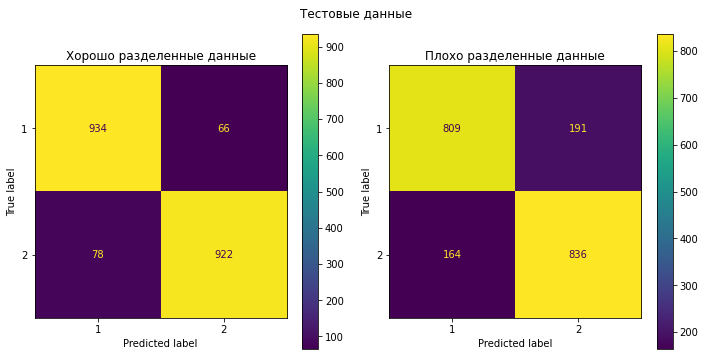

Эмпирическая вероятность ошибочной классификации:
	Хорошо разделенные данные: 
		P(1|2) = 0.078, P(2|1) = 0.066
	Плохо разделенные данные: 
		P(1|2) = 0.164, P(2|1) = 0.191


In [7]:
cm_good_test = confusion_matrix(true_good, predict_good)
cm_bad_test = confusion_matrix(true_bad, predict_bad)

def confusion_matrix_report(cm_good, cm_bad, suptitle: str, err_name: str, R_good, R_bad):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ConfusionMatrixDisplay(cm_good, display_labels=["1", "2"]).plot(ax=ax[0])
    ax[0].set_title("Хорошо разделенные данные")
    ConfusionMatrixDisplay(cm_bad, display_labels=["1", "2"]).plot(ax=ax[1])
    ax[1].set_title("Плохо разделенные данные")
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.show()

    print(err_name + ":")

    _, m21, m12, _ = cm_good.ravel()
    print(f"\tХорошо разделенные данные: \n\t\tP(1|2) = {m12 / R_good.n2}, P(2|1) = {m21 / R_good.n1}")

    _, m21, m12, _ = cm_bad.ravel()
    print(f"\tПлохо разделенные данные: \n\t\tP(1|2) = {m12 / R_bad.n2}, P(2|1) = {m21 / R_bad.n1}")
    
confusion_matrix_report(cm_good_test, cm_bad_test, suptitle='Тестовые данные', 
                        err_name='Эмпирическая вероятность ошибочной классификации', R_good=R_good, R_bad=R_bad)


### Исследование классификации исходной обучающей выборки

Укажем тестовую выборку (без аргумента *create_new=True* в методе **specify_test_set()** в качестве классифицируемых указываются исходные обучающие выборки)

In [8]:
true_good = R_good.specify_test_set()
true_bad = R_bad.specify_test_set()
predict_good = R_good.predict()

predict_bad = R_bad.predict()

<a id="cell_Makh"></a>

Рассчитаем оценки вероятностей ошибочной классификации:

$$\hat{P}(1|2) = \frac{m_2}{n_2}$$
$m_2$ - количество элементов 2 класса, которых классификатор определил как 1 класс

$$\hat{P}(2|1) = \frac{m_1}{n_1}$$
$m_1$ - количество элементов 1 класса, которых классификатор определил как 2 класс

И построим четырехпольную таблицу сопряженности.

__А также (чтобы было удобно сравнивать) вновь выведем четырехпольную таблицу и эмпирические вероятности по итогам классификации тестовой выборки.__

С той же целью сразу выведем несмещенную оценку расстояния Махаланобиса:

$$D^2_н = \frac{n_1+n_2-p-3}{n_1+n_2-2}D^2-p(\frac{1}{n_1}+\frac{1}{n_2}), \quad\ p=3$$

гдe $$D^2 = \frac{(\overline{z}^{(1)} - \overline{z}^{(2)})^2}{s_z^2}$$

И оценки вероятностей ошибочной классификации:

$$\hat{P}(2|1) = Ф\Bigg(\cfrac{K-\frac{1}{2}D_н^2}{D_н}\Bigg) $$

$$\hat{P}(1|2) = Ф\Bigg(\cfrac{-K-\frac{1}{2}D_н^2}{D_н}\Bigg)$$

$$Ф(y)=\cfrac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^{y}e^{-\frac{t^2}{2}}dt$$

$$K=ln\bigg( \cfrac{q_2 c(1|2)}{q_1 c(2|1)} \bigg)$$

Где $c(1|2), c(2|1)$ - стоимости ошибочной классификации

В нашем случае $q_1=q_2=0.5$, а $c(1|2)=c(2|1)$ так как задача не предполагает выделения важности конкретной ошибки. Следовательно $K=0$.

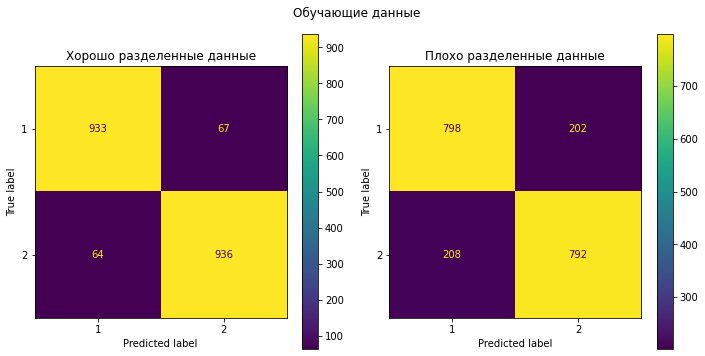

Оценка вероятности ошибочной классификации:
	Хорошо разделенные данные: 
		P(1|2) = 0.064, P(2|1) = 0.067
	Плохо разделенные данные: 
		P(1|2) = 0.208, P(2|1) = 0.202


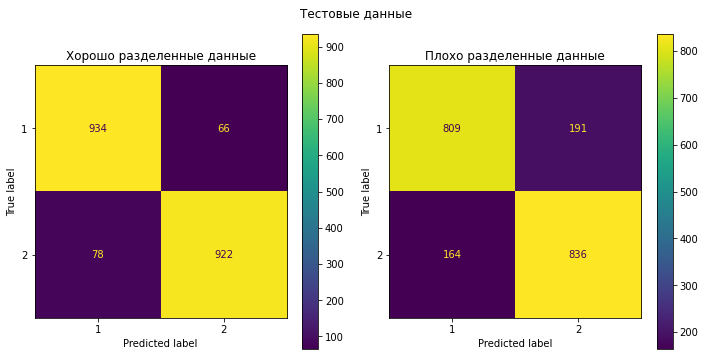

Эмпирическая вероятность ошибочной классификации:
	Хорошо разделенные данные: 
		P(1|2) = 0.078, P(2|1) = 0.066
	Плохо разделенные данные: 
		P(1|2) = 0.164, P(2|1) = 0.191

Хорошо разделенные данные:
	Несмещенная оценка расстояния Махаланобиса: 3.043
	Несмещенные оценки ошибочной классификации: P(2|1) = 0.064	 P(1|2) = 0.064
Плохо разделенные данные:
	Несмещенная оценка расстояния Махаланобиса: 1.682
	Несмещенные оценки ошибочной классификации: P(2|1) = 0.2	 P(1|2) = 0.2


In [9]:
cm_good = confusion_matrix(true_good, predict_good)
cm_bad = confusion_matrix(true_bad, predict_bad)

confusion_matrix_report(cm_good, cm_bad, suptitle='Обучающие данные', 
                        err_name='Оценка вероятности ошибочной классификации', R_good=R_good, R_bad=R_bad)
confusion_matrix_report(cm_good_test, cm_bad_test, suptitle='Тестовые данные', 
                        err_name='Эмпирическая вероятность ошибочной классификации', R_good=R_good, R_bad=R_bad)

print()

for header, research in zip(["Хорошо разделенные данные:", "Плохо разделенные данные:"],
                            [R_good, R_bad]):
    print(header)
    makh = research.makhalanobis(unbiased=True)
    errors = research.calc_errors(makh)
    print(f"\tНесмещенная оценка расстояния Махаланобиса: {round(makh, 3)}",)
    print(f"\tНесмещенные оценки ошибочной классификации: P(2|1) = {round(errors['p21'], 3)}\t P(1|2) = {round(errors['p12'], 3)}")

#### Сравнительный анализ

Заметим, что и для тестовой выборки, и для обучающих данных, классикация хорошо разделенных данных получается качественнее - эмипирическая вероятность ошибочной классификации и ее оценка в обоих случаях ниже нежели в случае плохо разделенных данных.

Что и требовалось ожидать - расстояние Махалонобиса и оценки вероятностей ошибочной классификации больше в случае плохо разделенных данных.

## Реализация: данные из репозитория

---

### Построение дискриминантной функции по обучающей выборке, классификация тестовой выборки

Исследуем качество классификации на данных датасета *german-numeric*. Размер датасета - 1000, 700 из них принадлежит классу №1, 300 - №2. Число признаков - 24.

In [10]:
class RepoResearch:
    def __init__(self, x, y, train_coef):
        logging = True
        self.X = x
        self.Y = y
        
        self.sample1 = self.X[self.Y == 1]
        self.sample2 = self.X[self.Y == 2]
        
        size1 = len(self.sample1)
        size2 = len(self.sample2)
        if logging:
            print(f"Всего данных: \t\t1: {size1} \t2: {size2}")
            
        self.train1 = self.sample1[:int(train_coef*size1)]
        self.train2 = self.sample2[:int(train_coef*size2)]
        self.train_trueY = np.hstack([np.ones(len(self.train1)), np.full(len(self.train2), 2)])
        self.train_set = np.vstack([self.train1, self.train2])
        self.train_n1 = len(self.train1)
        self.train_n2 = len(self.train2)
        
        self.test1 = self.sample1[int(train_coef*size1):]
        self.test2 = self.sample2[int(train_coef*size2):]
        # true targets
        self.test_trueY = np.hstack([np.ones(len(self.test1)), np.full(len(self.test2), 2)])
        self.test_set = np.vstack([self.test1, self.test2])
        self.test_n1 = len(self.test1)
        self.test_n2 = len(self.test2)
        
        if logging:
            print(f"Тренировочные данные: \t1: {len(self.train1)} \t2: {len(self.train2)}")
            print(f"Тестовые данные: \t1: {len(self.test1)} \t2: {len(self.test2)}")
        
        self.q1 = len(self.train1) / (len(self.train1) + len(self.train2))
        self.q2 = 1-self.q1
        
        if logging:
            print(f"q1 = {self.q1}, \tq2 = {round(self.q2, 2)}")
        
    def calc_estimates(self):
#         samples mean
        self.m1_ = np.mean(self.train1, axis=0)
        self.m2_ = np.mean(self.train2, axis=0)
        
#         specify covariance matrix for samples
#         assuming that cov1 approximately equal cov2
        self.cov_ = ((len(self.train1)-1)*np.cov(self.train1.T) + (len(self.train2)-1)*np.cov(self.train2.T)) / (len(self.train1) + len(self.train2) - 2)
        
        self.alpha = np.linalg.inv(self.cov_) @ (self.m1_-self.m2_)
#         mean of discriminant function
        self.mz1_ = np.dot(self.alpha, self.m1_)
        self.mz2_ = np.dot(self.alpha, self.m2_)
#         variance of discriminant function
        self.z_var = self.alpha @ self.cov_ @ self.alpha
    
    def makhalanobis(self, unbiased=False):        
        makh = (self.mz1_-self.mz2_)**2 / self.z_var
        if unbiased:
            p = len(self.m1_)
            n1 = self.train_n1
            n2 = self.train_n2
            makh = ((n1 + n2 - p - 3) / (n1 + n2 - 2)*makh - p*(1/n1 + 1/n2))**0.5
        return makh
    
    def calc_errors(self, D):
        K = np.log(self.q2 / self.q1)
        F = lambda x: norm.cdf(x)
        return {"p21": F((K - 0.5*D**2)/D), "p12": F((-K - 0.5*D**2)/D)}
    
        
    def predict(self, predict_test_set=True):
        if predict_test_set:
            predict_set = self.test_set
        else:
            predict_set = self.train_set
        threshold = (self.mz1_ + self.mz2_) / 2
        lnq1q2 = np.log(self.q2 / self.q1)
        threshold += lnq1q2
        predict = []
        for instance in predict_set:
            if np.dot(self.alpha, instance) >= threshold:
                predict.append(1)
            else:
                predict.append(2)
        return predict
        

Для обучения берем 90% данных датасета. 630 от 1-го класса, 270 от 2-го.

In [11]:
X = []
Y = []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        x, y = string[:-1], string[-1]
        X.append(np.array(list(map(lambda elem: float(elem), x))))
        Y.append(int(y))
X = np.array(X)
Y = np.array(Y)

repo_research = RepoResearch(X, Y, 0.9)
repo_research.calc_estimates()


Всего данных: 		1: 700 	2: 300
Тренировочные данные: 	1: 630 	2: 270
Тестовые данные: 	1: 70 	2: 30
q1 = 0.7, 	q2 = 0.3


Найдем эмпирическую вероятность ошибочной классификации.

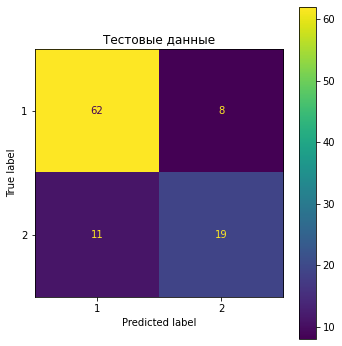

Эмпирические вероятности ошибочной классификации: 
	P(1|2) = 0.367, P(2|1) = 0.114


In [12]:
predict = repo_research.predict(predict_test_set=True)

cm_test = confusion_matrix(repo_research.test_trueY, predict)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ConfusionMatrixDisplay(cm_test, display_labels=["1", "2"]).plot(ax=ax)
ax.set_title("Тестовые данные")
fig.tight_layout()
plt.show()

_, m21, m12, _ = cm_test.ravel()
p12_test, p21_test = round(m12 / repo_research.test_n2, 3), round(m21 / repo_research.test_n1, 3)
print(f"Эмпирические вероятности ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research.test_n2, 3)}, P(2|1) = {round(m21 / repo_research.test_n1, 3)}")

<a id="report_wo_pca"></a>

### Исследование классификации исходной обучающей выборки из репозитория

---

Вычислим оценки вероятностей ошибочной классификации, а также несмещенную оценку расстояние Махаланобиса и несмещенные оценки вероятностей ошибочной классификации по ранее упомянутым [формулам 17-22](#cell_Makh).

Также для удобства сравнения выведем рядом четырехпольную таблицу сопряженности и эмпирические вероятности по итогам классификации тестовой выборки.

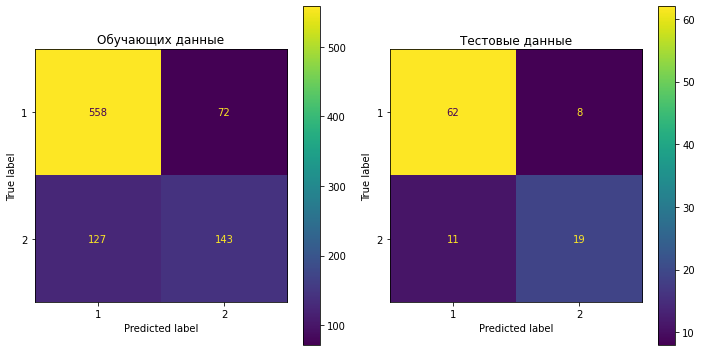

Оценки вероятностей ошибочной классификации: 
	P(1|2) = 0.47,	 P(2|1) = 0.114
Несмещенная оценка расстояния Махаланобиса: 1.198
Несмещенные оценки ошибочной классификации: P(1|2) = 0.543 	 P(2|1) = 0.096
Эмпирические вероятности ошибочной классификации: 
	P(1|2) = 0.367, P(2|1) = 0.114


In [13]:
predict = repo_research.predict(predict_test_set=False)

cm = confusion_matrix(repo_research.train_trueY, predict)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ConfusionMatrixDisplay(cm, display_labels=["1", "2"]).plot(ax=ax[0])
ax[0].set_title("Обучающих данные")
ConfusionMatrixDisplay(cm_test, display_labels=["1", "2"]).plot(ax=ax[1])
ax[1].set_title("Тестовые данные")
fig.tight_layout()
plt.show()

_, m21, m12, _ = cm.ravel()
print(f"Оценки вероятностей ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research.train_n2, 3)},\t P(2|1) = {round(m21 / repo_research.train_n1, 3)}")

makh = repo_research.makhalanobis(unbiased=True)
errors = repo_research.calc_errors(makh)
print(f"Несмещенная оценка расстояния Махаланобиса: {round(makh, 3)}")
print(f"Несмещенные оценки ошибочной классификации: P(1|2) = {round(errors['p12'], 3)} \t P(2|1) = {round(errors['p21'], 3)}")

print(f"Эмпирические вероятности ошибочной классификации: \n\tP(1|2) = {p12_test}, P(2|1) = {p21_test}")

Чтобы сразу перейти к отчету по классификации после понижения размерности нажмите [**здесь**](#report_w_pca)

## Метод главных компонент

---

### Исследование классификации тестовой выборки из репозитория c уменьшенной размерностью данных (PCA)

---

Попробуем предобработать данные. Сократим число признаков с помощью метода главных компонент.

Стандартизуем данные, вычислим несмещенную оценку матрицы ковариаций. Вычислим собственные значения и векторы. Отберем наиболее значимые признаки, домножив матрицу признаков на матрицу состоящую из собственных векторов, собcтвенные числа которых удовлетворяют неравенству (правило Кайзера):

$$\lambda_i: \cfrac{\lambda_i}{\sum\limits_{j=1}^{p=24}D[x_j]}=\cfrac{\lambda_i}{trace(S)}>\cfrac{1}{24}$$

Так как данные были стандартизированы, то отбор собственных чисел становится следующим:

$$\lambda_i: \lambda_i > 1$$

In [14]:
X = []
Y = []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        x, y = string[:-1], string[-1]
        X.append(np.array(list(map(lambda elem: float(elem), x))))
        Y.append(int(y))
X = np.array(X)
Y = np.array(Y)

mean = np.mean(X, axis=0)
covariance = np.cov(X.T)
X_centered = X - mean
X_stand = X_centered / np.sqrt(np.diagonal(covariance))

covariance = np.cov(X_stand.T)

eiges = np.linalg.eig(covariance)

values, vectors = eiges
eiges = sorted(list(zip(values, vectors.T)), key=lambda x: x[0], reverse=True)

vals = values[values > 1]
print(f"Отобрали следующие {len(vals)} собcтвенных чисел: {vals}")



Отобрали следующие 10 собcтвенных чисел: [2.51828975 2.12147659 1.85393992 1.70397873 1.63217357 1.32147521
 1.21521006 1.15970619 1.12146973 1.01054463]


Далее произведем перемножение матриц:

$$X[1000, 24]\cdot Transform[24, 10] = X_{new}[1000, 10]$$

Числа в скобках отображают размерности матриц. Матрица $Transform[24, 10]$ состоит из собственных векторов, соответствующих отобранным собственным значениям.

In [15]:
transform_ = np.vstack(list([eiges[i][1] for i in range(10)]))
X_new = X_stand @ transform_.T + mean @ transform_.T

In [16]:
repo_research_PCA = RepoResearch(X_new, Y, 0.9)
repo_research_PCA.calc_estimates()

Всего данных: 		1: 700 	2: 300
Тренировочные данные: 	1: 630 	2: 270
Тестовые данные: 	1: 70 	2: 30
q1 = 0.7, 	q2 = 0.3


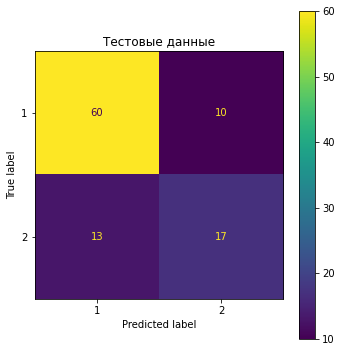

Эмпирические вероятности ошибочной классификации: 
	P(1|2) = 0.433, P(2|1) = 0.143


In [17]:
predict = repo_research_PCA.predict(predict_test_set=True)

cm_test_pca = confusion_matrix(repo_research_PCA.test_trueY, predict)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ConfusionMatrixDisplay(cm_test_pca, display_labels=["1", "2"]).plot(ax=ax)
ax.set_title("Тестовые данные")
fig.tight_layout()
plt.show()

_, m21, m12, _ = cm_test_pca.ravel()
p12_test_pca, p21_test_pca = round(m12 / repo_research_PCA.test_n2, 3), round(m21 / repo_research_PCA.test_n1, 3)
print(f"Эмпирические вероятности ошибочной классификации: \n\tP(1|2) = {p12_test_pca}, P(2|1) = {p21_test_pca}")

<a id="report_w_pca"></a>

### Исследование классификации исходной обучающей выборки из репозитория c уменьшенной размерностью данных (PCA)

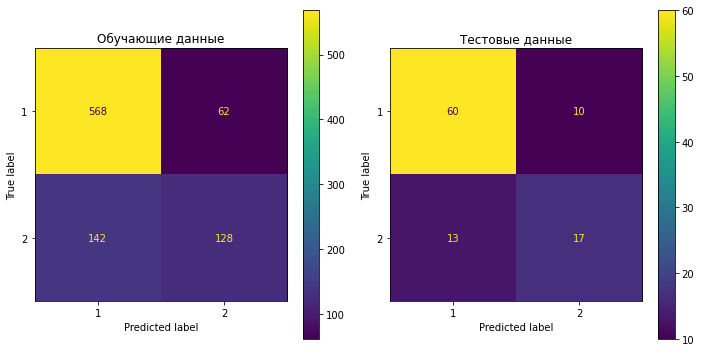

Оценки вероятностей ошибочной классификации: 
	P(1|2) = 0.526, P(2|1) = 0.098
Эмпирические вероятности ошибочной классификации: 
	P(1|2) = 0.433, P(2|1) = 0.143


In [18]:
predict = repo_research_PCA.predict(predict_test_set=False)

cm = confusion_matrix(repo_research_PCA.train_trueY, predict)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ConfusionMatrixDisplay(cm, display_labels=["1", "2"]).plot(ax=ax[0])
ax[0].set_title("Обучающие данные")
ConfusionMatrixDisplay(cm_test_pca, display_labels=["1", "2"]).plot(ax=ax[1])
ax[1].set_title("Тестовые данные")
fig.tight_layout()
plt.show()

_, m21, m12, _ = cm.ravel()
print(f"Оценки вероятностей ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research_PCA.train_n2, 3)}, P(2|1) = {round(m21 / repo_research_PCA.train_n1, 3)}")

print(f"Эмпирические вероятности ошибочной классификации: \n\tP(1|2) = {p12_test_pca}, P(2|1) = {p21_test_pca}")

In [19]:
makh = repo_research_PCA.makhalanobis(unbiased=True)
errors = repo_research_PCA.calc_errors(makh)
print(f"\tНесмещенная оценка расстояния Махаланобиса: {round(makh, 3)}")
print(f"\tНесмещенные оценки ошибочной классификации: P(1|2) = {round(errors['p12'], 3)} \t P(2|1) = {round(errors['p21'], 3)}")

	Несмещенная оценка расстояния Махаланобиса: 1.14
	Несмещенные оценки ошибочной классификации: P(1|2) = 0.569 	 P(2|1) = 0.095


Чтобы сравнить с классификацией на обучающей и тестовой выборках без понижения размерности нажмите [**здесь**](#report_wo_pca).

Посмотрим на данные c пониженной размерностью:

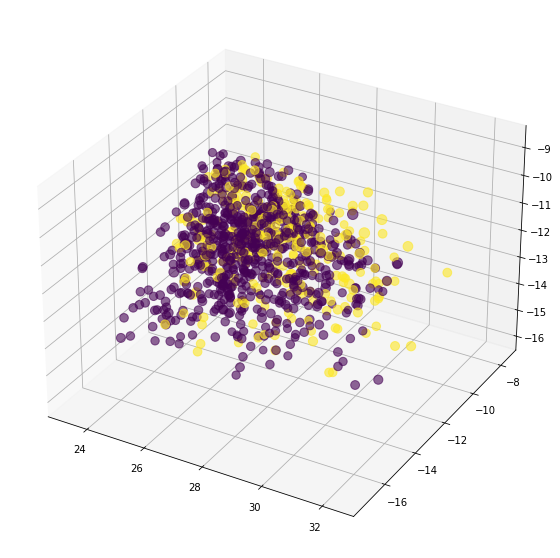

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=X_new[:, 0], ys=X_new[:, 1], zs=X_new[:, 2], s=(X_new[:, 3]**2)**(0.75), alpha=0.6, c=Y);

## Выводы по PCA

Понижение размерности может уменьшить сложность вычислений. Но уменьшив число признаков более чем в два раза, пришлось пожертвовать точностью выделения объектов второго класса.

Однако в данном случае вероятность ошибки второго класса приближается к 0.5, что создает сомнения в смысле использования такого классификатора - случайный выбор мог определять второй класс с тем же успехом.

Но все же стоит отметить, что любой классификатор имеет смысл оценивать в контексте прикладной задачи. Например, в данном случае и эмпирическая $P_{э}(2|1)$, и $\hat{P}(2|1)$ довольны малы и незначительно изменяются при понижении размерности. Если бы задачей стояло как можно реже определять 1-ый класс класс как 2-ой класс (например, определять террориста, как добропорячного гражданина или больного человека как здорового), то наш классификатор неплохо справлялся бы.

Визуальное представление данных помогает увидеть, что данные все еще сильно спутаны и не разделяются линейно.

# Заключение

---

- Пронаблюдали зависимость качества классификации от разброса данных при равных средних. Высокая дисперсия является причиной более пологой функции плотности случайной величины значения дискриминантной функции, что усложняет классификацию - данные смешаны в такой случае сильнее.

- В случае неравномерного (несбалансированного) содержания объектов разных классов в обучающей выборке повышается вероятность ошибиться, объекты малочисленного класса довольно часто относятся классификатором к многочисленному классу. В таких случаях, полагаясь на контекст задачи, имеет смысл вводить стоимости ошибочной классификации.

- Сокращение размерности пространства признаков в разумных пределах (что можно определить, например, правилом Кайзера) позволяет снизить вычислительные требования классификатора. При этом вероятность ошибки может незначительно вырасти.